Bathtub (current): https://climada-petals.readthedocs.io/en/stable/tutorial/climada_hazard_TCSurgeBathtub.html

<br>

As a first approximation, the tropical cyclone’s wind field in each grid cell is used as an input to a simplified version of the wind-surge relationship in Xu (2010), which is based on pre-run SLOSH outputs.

<br>

env installation: https://climada-python.readthedocs.io/en/stable/guide/install.html#install-simple


```
cd <path/to/workspace>
curl -o env_climada.yml https://raw.githubusercontent.com/CLIMADA-project/climada_python/main/requirements/env_climada.yml
conda env create -n climada_env -f env_climada.yml
conda activate climada_env
conda install -nn climada_env --experimental-solver=libmamba ipykernel notebook
python -m pip install climada
python -m ipykernel install --user --n climada_env
python -m unittest climada.engine.test.test_impact

git clone <climada_petals github>
```

[Install CLIMADA petals](https://climada-petals.readthedocs.io/en/latest/)
[Github for CLIMADA petals](https://github.com/CLIMADA-project/climada_petals) <br>
Downloaded SRTM from [here](https://figshare.com/projects/SRTM15_V2_0/62045). But OpenTopography let's you just download a subset. <br>
This is recommended as available on request [here]. (https://go.climatecentral.org/coastaldem/) and read more [here](https://www.climatecentral.org/coastaldem-v2.1).


# Demo

In [1]:
# settings
STORM = "roanu"
REGION = "satkania"
NSUBREGIONS = 1
SUBREGION = 0

from os.path import join
from climada_petals.hazard import TCSurgeBathtub
from climada.util.constants import DEMO_DIR
from climada.hazard import TCTracks
import geopandas as gpd
import numpy as np
from climada.hazard import TropCyclone, Centroids
import matplotlib.pyplot as plt
from event import Event

def to_numpy(self, attribute, size=64):
    """Convert helper class back to numpy matrix."""
    return np.reshape(getattr(self, attribute), (size, size)).T

Centroids.to_numpy = to_numpy

plt.rcParams['font.family'] = 'Arial'

# set up env
bd = '.'
wd = join(bd, "..", "data")
figure_settings = {'bbox_inches': 'tight', 'dpi': 400}

# load event GeoDataFrame (as when getting data)
event = Event(STORM, REGION, NSUBREGIONS, wd, bd)
event.make_grids()
self = event

In [2]:
event.aoi_lonlat[SUBREGION].bounds

,minx,miny,maxx,maxy
0,91.744545,21.898834,92.032006,22.165303


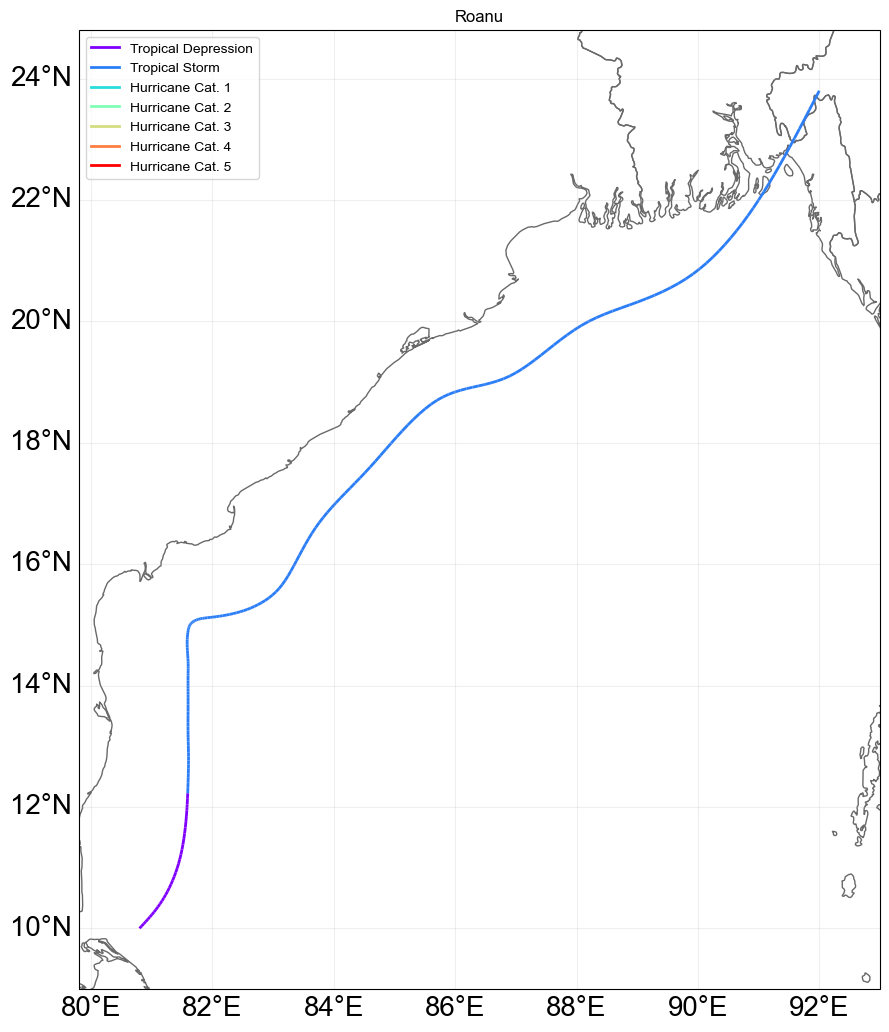

In [3]:
ibtracs = TCTracks.from_ibtracs_netcdf(provider='usa', storm_id=[self.sid]) # SIDR 2007 and ROANU 2016
ibtracs.equal_timestep(0.5)
ax = ibtracs.plot()
ax.get_legend()._loc = 2 # correct legend location
ax.set_title(STORM.capitalize()); # set title

In [4]:
# import pandas as pd
# from datetime import datetime

# starttime = pd.to_datetime(self.startdate)
# endtime = pd.to_datetime(self.acquisition_time)

# ibtracs.data[0] = ibtracs.data[0].sel(time=slice(starttime, endtime))

In [8]:
# 2: wind gusts computation

self.get_elevation(SUBREGION, recalculate=False)

aoi = self.aoi_lonlat[SUBREGION]
grid = self.feature_gdf[SUBREGION]
grid_centroid = grid.set_geometry(grid.to_crs(3857).centroid).to_crs(4326)

geometry = grid_centroid.geometry
lat = geometry.y.to_numpy(copy=True)
lon = geometry.x.to_numpy(copy=True)
centroids = Centroids(lat=lat, lon=lon, geometry=geometry)

for col in grid_centroid.columns:
    if col in ['geometry', 'lat', 'lon']:
        continue 
    val = grid_centroid[col].to_numpy(copy=True)
    setattr(centroids, col, val)

if centroids.on_land.size == 0:
    try:
        centroids.on_land = ~np.isnan(centroids.region_id)
    except KeyError:
        pass


centroids.set_dist_coast(signed=True, precomputed=True)
centroids.check()

wind_field = TropCyclone.from_tracks(ibtracs, centroids=centroids)

<AxesSubplot:>

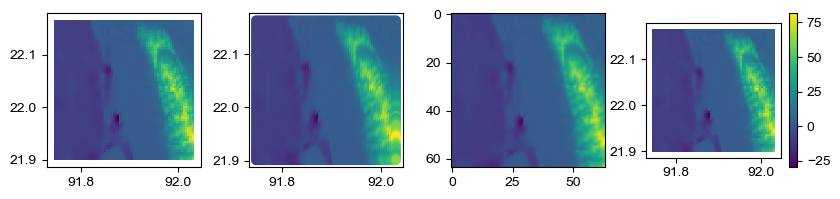

In [9]:
# check all conversions look okay
fig, ax = plt.subplots(1, 4, figsize=(10, 2))

grid.plot('elevation', ax=ax[0])
grid_centroid.plot('elevation', ax=ax[1])
ax[2].imshow(np.reshape(centroids.elevation, (64, 64)).T)
grid['centroid_elev'] = centroids.elevation
grid.plot('centroid_elev', ax=ax[3], legend=True)

In [10]:
# 3: surge computation (need to replace with better DTM)

# If you have the global SRTM15+V2.0 elevation data set, you can replace the following
# sample DEM data set by your SRTM15+V2.0.tiff:
topo_path = DEMO_DIR.joinpath(f'{STORM}_{REGION}.tif')
topo_path = join(wd, f'{STORM}_{REGION}', 'FABDEM.tif')

surge = TCSurgeBathtub.from_tc_winds(wind_field, topo_path)

<GeoAxesSubplot:>

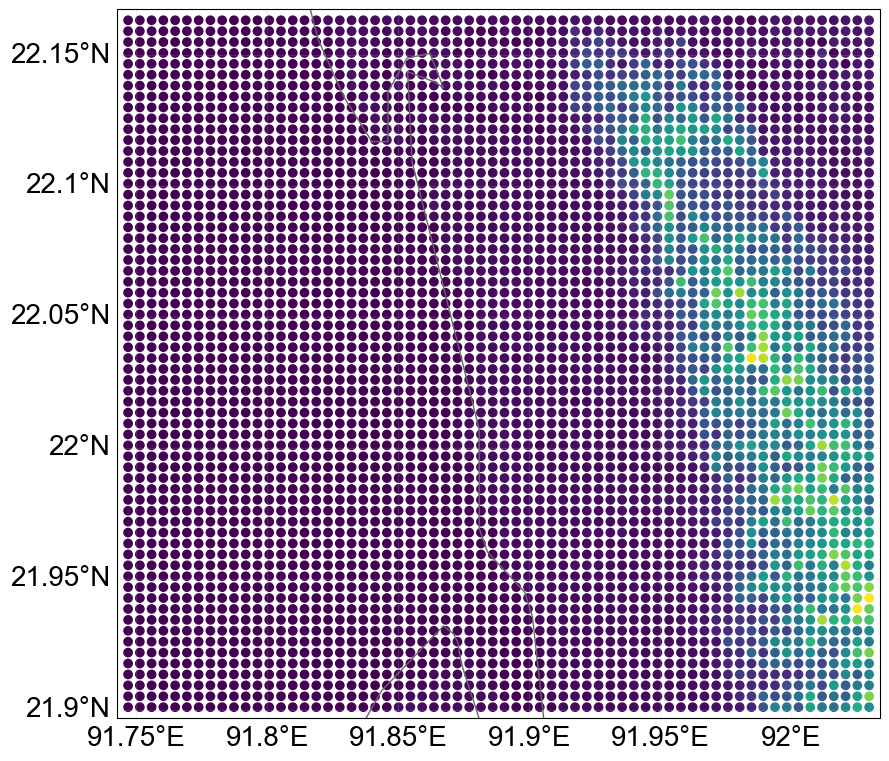

In [11]:
surge.centroids.set_elevation(topo_path)
surge.centroids.plot(c=surge.centroids.elevation)

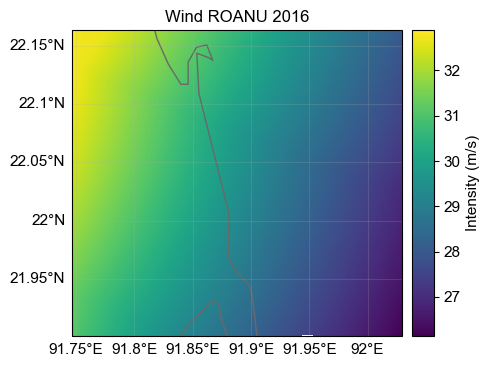

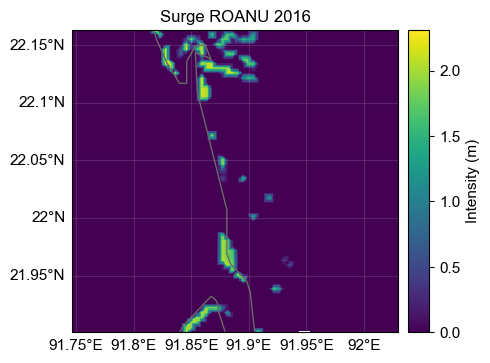

In [27]:
# plot wind and surge ROANU
ax = wind_field.plot_intensity(1, figsize=(5, 5))
ax.set_title('Wind ROANU 2016')
ax = surge.plot_intensity(1, figsize=(5, 5))
ax.set_title('Surge ROANU 2016');

In [13]:
grid['climada_wind'] = wind_field.intensity.todense().reshape(64 * 64).tolist()[0]
grid['climada_surge'] = surge.intensity.todense().reshape(64 * 64).tolist()[0]

<AxesSubplot:>

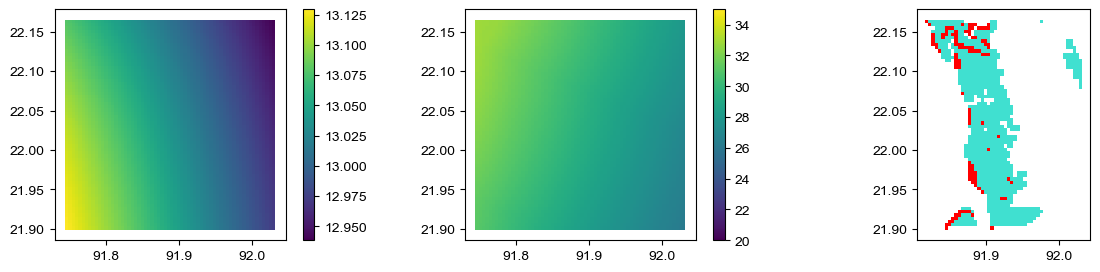

In [24]:
import data_utils

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

grid.plot('wind_avg', ax=ax[0], legend=True)
grid.plot('climada_wind', ax=ax[1], vmin=20, vmax=35, legend=True)

grid[grid.floodfrac > data_utils.floodthresh].plot(color='turquoise', ax=ax[2], zorder=0)
grid[grid.climada_surge > data_utils.floodthresh].plot(color='red', ax=ax[2], zorder=1, legend=True)

fig.savefig()


In [123]:
self.feature_gdf[SUBREGION] = grid
self.save_gdf(SUBREGION)

In [25]:
imdir

NameError: name 'imdir' is not defined